## Basic implementation of a perceptron network with pytorch
Notebook generates two concentric circles one inside the other and  
creates a model to build a decision boundary with simple MLP

In [134]:
# make notebook wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt

In [136]:
import torch
import torch.nn as nn # various building blocks of neural networks
import torch.optim as optim # optimization algorythms
import torch.nn.functional as F # low level api
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles 

import numpy as np

In [137]:
class myCircle(Dataset):
    """
    define a class to manipulate the data
    """
    def __init__(self, data, transform=None):
        """
        constructor - get data into the object
        0 - Red  
        1 - Green
        """
        self.data, self.labels = data[0], data[1]
        self.colors = list(map(lambda x: 'Red' if x == 0 else 'Green', self.labels))
        self.transform = transform # actually not used here but is a must in image processing
        self.len = len(self.data)
        
    def __getitem__(self, index):
        """
        method to get a single element of a data
        """
        try :
            if self.transform is not None:
                return(self.transform(self.data[index]), self.labels[index])
            else:
                return(self.data[index], self.labels[index])
        except IndexError:
            print("Index error")
            retrurn(None, None)
    def __len__(self):
        return(self.len)
    
    def display_data(self):
        """
        display a plot with the data
        """
        plt.figure(figsize=(10,10))
        plt.axis('equal')
        plt.scatter(self.data[:,0], self.data[:,1], c = self.colors)
        plt.show()
        
    def __repr__(self):
        return("I am the circles object. I contain %s points."%self.len)

In [138]:
# make data points with sklearn make_circles
data = make_circles(n_samples=5000, noise=0.15, factor=0.45)

In [139]:
# data[0] - x & y coordinates
# data[1] - color labels 
data[0], data[1]

(array([[ 0.86877516, -0.27434476],
        [ 0.42529629,  0.22622736],
        [-0.77358779, -0.51762525],
        ...,
        [ 0.21620699, -1.23487888],
        [ 0.3701718 , -0.0967712 ],
        [-0.33733825, -0.17525048]]), array([0, 1, 0, ..., 0, 1, 1]))

In [140]:
# split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(data[0], data[1], test_size=0.5)
X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float() # input data must be a tensor
Y_train, Y_test = torch.from_numpy(Y_train), torch.from_numpy(Y_test) # response coud be whatever

In [141]:
X_train, Y_train

(tensor([[ 0.1349,  0.4780],
         [-0.2316, -1.2958],
         [ 0.6736,  0.6211],
         ...,
         [-0.6689, -0.6702],
         [ 0.6231, -0.7044],
         [-0.2306, -0.4056]]), tensor([1, 0, 0,  ..., 0, 0, 1]))

In [142]:
# these are the two main Dataset object that hold the data and 
train_circles, test_circles = myCircle([X_train, Y_train]), myCircle([X_test, Y_test])

In [143]:
train_circles, test_circles

(I am the circles object. I contain 2500 points.,
 I am the circles object. I contain 2500 points.)

In [144]:
# 1-st element of input and label data
train_circles.data[0], train_circles.labels[0]

(tensor([0.1349, 0.4780]), tensor(1))

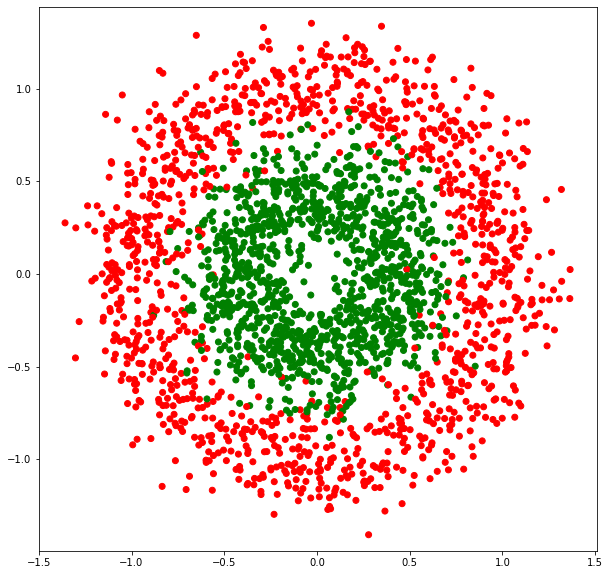

In [145]:
train_circles.display_data()

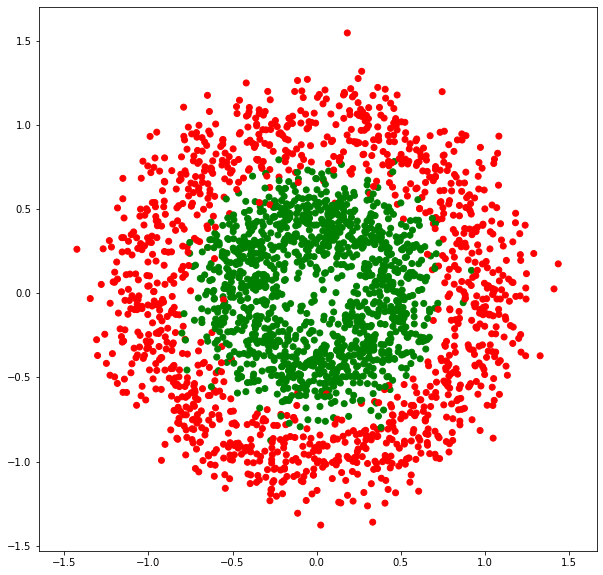

In [146]:
test_circles.display_data()

In [153]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(DEVICE)

cuda:0


### Define loaders that will organize the data into mini-batches for learning

In [127]:
trainLoader = DataLoader(dataset = train_circles, 
                         batch_size=128, 
                         shuffle=True)

# for the test batch_size = all data volume
testLoader = DataLoader(dataset = test_circles, 
                        batch_size=len(test_circles), 
                        shuffle=False)

In [132]:
class CirclesPerceptronSequential(nn.Module):
    def __init__(self, number_hidden=6):
        super(CirclesPerceptronSequential, self).__init__()
        self.net = nn.Sequential(*[nn.Linear(2, number_hidden), # incoming layer: 2 inputs -> number of hidden neurons
                                   nn.ReLU(),  # activation after hidden layer
                                   nn.Linear(number_hidden, 1),  # output to one number
                                   nn.Sigmoid()]) # make that a probability of a positive class
        
        self.criterion = nn.BCEWithLogitsLoss()    # loss function -> binary cross entropy
        
        self.optimizer = optim.Adam(self.parameters()) # optimizer - Adam
        
    def forward(self, x):
        return(self.net(x))

In [133]:
circles_nn = CirclesPerceptronSequential()

In [33]:
print(circles_nn) 


myPerceptronSequential(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (criterion): BCEWithLogitsLoss()
)


In [34]:
# sample output of forward pass from a single input
circles_nn.forward(train_circles.data[0])

tensor([0.5645], grad_fn=<SigmoidBackward>)

In [35]:
# sample output of forward pass from a multiple input
circles_nn.forward(train_circles.data[0:3])

tensor([[0.5645],
        [0.5276],
        [0.5109]], grad_fn=<SigmoidBackward>)

In [36]:
# make a device variable
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [37]:
def train(model, dataLoader, optimizer, criterion, epoch=10, log_interval=100):
    """
    routine to train a model
    ---
    parameters:
    model - nn model to train
    dataLoader - data loader of a torch class DataLoader
    optimizer - optimizer, i.e. SBD, Adam...
    epoch - number of times to iterate over the data
    log_interval - number of optimizer steps between printing output
    """
    from time import time
    model.train()  # put model into a train mode
    iteration = 0 # mini-batch counter

    for ep in range(epoch): # loop over epochs
        start = time()
        
        # loop over the whole dataset - that is one epoch
        
        for batch_idx, (data, target) in enumerate(dataLoader): 
            
            # put the data to device
            data, target = data.to(device), target.to(device).float() 
            
            # calculate forward pass
            output = model.forward(data)
            # calculate the loss
            loss = criterion(output.view(-1), target)
            
            # backward pass started
            # clear all gradients
            optimizer.zero_grad()
            # calculate derivatives of loss wrt to all nn parameters
            loss.backward()
            # make a step towards the minima of the loss
            optimizer.step()
            
            # output progress and loss
            # len(trainLoader) - # of mini-batches in the dataset
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainLoader.dataset),
                    100.* (batch_idx+1) / len(trainLoader), loss.item()))
                
            iteration += 1
        
        end = time()
        #print('{:.2f}s'.format(end-start))
    

In [38]:
# send model to device
model  = circles_nn.to(device)
model

myPerceptronSequential(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (criterion): BCEWithLogitsLoss()
)

In [39]:
train(model, trainLoader, model.optimizer, model.criterion, epoch=300, log_interval=500)

Train Epoch: 0 [0/3750 (3%)]	Loss: 0.717739
Train Epoch: 16 [2560/3750 (70%)]	Loss: 0.698983
Train Epoch: 33 [1280/3750 (37%)]	Loss: 0.696948
Train Epoch: 50 [0/3750 (3%)]	Loss: 0.636479
Train Epoch: 66 [2560/3750 (70%)]	Loss: 0.605242
Train Epoch: 83 [1280/3750 (37%)]	Loss: 0.602009
Train Epoch: 100 [0/3750 (3%)]	Loss: 0.584229
Train Epoch: 116 [2560/3750 (70%)]	Loss: 0.570050
Train Epoch: 133 [1280/3750 (37%)]	Loss: 0.589283
Train Epoch: 150 [0/3750 (3%)]	Loss: 0.529127
Train Epoch: 166 [2560/3750 (70%)]	Loss: 0.552300
Train Epoch: 183 [1280/3750 (37%)]	Loss: 0.571819
Train Epoch: 200 [0/3750 (3%)]	Loss: 0.565717
Train Epoch: 216 [2560/3750 (70%)]	Loss: 0.514997
Train Epoch: 233 [1280/3750 (37%)]	Loss: 0.549523
Train Epoch: 250 [0/3750 (3%)]	Loss: 0.523711
Train Epoch: 266 [2560/3750 (70%)]	Loss: 0.528307
Train Epoch: 283 [1280/3750 (37%)]	Loss: 0.545141


In [41]:
torch.save(model.state_dict(), 'my_net.t7')

In [ ]:
!ls -lh *.t7

In [ ]:
model2.state_dict()

In [ ]:
model2.state_dict()['net.0.weight'].to('cpu').numpy()

In [ ]:
model2.state_dict()['net.0.bias'].to('cpu').numpy()

In [54]:
def draw_perceptron_boundary(weights, biases):
    x = np.linspace(-0.5,0.5,3)
    plt.figure(figsize=(10,10))
    plt.axis('equal')
    plt.scatter(train_circles.data[:,0], train_circles.data[:,1], c = train_circles.colors)
    for weight, bias in zip(weights, biases):
        plt.plot(x, -weight[0]*x/weight[1] - bias/weight[1])
    plt.show()

In [55]:
train_circles.data

tensor([[-0.5369,  0.1649],
        [-0.5489, -0.2348],
        [ 1.0049, -0.0357],
        ...,
        [-0.8875, -0.2351],
        [-0.9906, -0.0089],
        [ 0.5526, -0.7740]])

In [56]:
def model_metrics(data, labels, model):
    from sklearn.metrics import accuracy_score, recall_score, f1_score
    prediction = model.forward(data.to(device)).detach().to('cpu').argmax(dim=1).numpy()
    metrics = dict()
    metrics['accuracy'] = accuracy_score(labels.to('cpu').numpy(), prediction)
    metrics['recall'] = recall_score(labels.to('cpu').numpy(), prediction)
    metrics['f1score'] = f1_score(labels.to('cpu').numpy(), prediction)
    return(metrics)
    

In [57]:
scores = model.forward(train_circles.data.to(device)).detach().to('cpu').view(-1).numpy()
y = train_circles.labels.to('cpu').numpy()

In [58]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, scores)

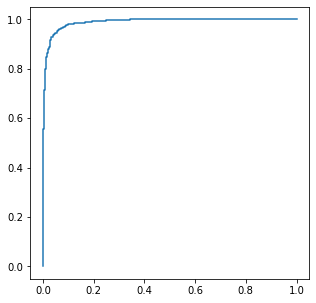

In [59]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.show()

In [60]:
def eucledean(dot1, dot2):
    return(np.sqrt(np.power(dot1[0]-dot2[0],2) + np.power(dot1[1]-dot2[1],2)))

In [61]:
dist = np.array([eucledean((0,1),(x,y)) for x,y in zip(fpr,tpr)])

In [62]:
dist.argmin(), dist[dist.argmin()]

(188, 0.07344062494665045)

In [63]:
THRESHOLD = thresholds[dist.argmin()]
THRESHOLD

0.277019

In [68]:
def model_metrics2(data, labels, thereshold, model):
    from sklearn.metrics import accuracy_score, recall_score, f1_score
    
    labels = labels.to('cpu').numpy()
    scores = model.forward(data.to(device)).detach().to('cpu').view(-1).numpy()
    prediction = (scores >= thereshold).astype(int)
    
    metrics = dict()
    metrics['accuracy'] = accuracy_score(labels, prediction)
    metrics['recall'] = recall_score(labels, prediction)
    metrics['f1score'] = f1_score(labels, prediction)
    
    plt.figure(figsize=(10,10))
    plt.axis('equal')
    data = data.to(device).detach().to('cpu').numpy()
    plt.scatter(data[:,0],data[:,1], c=prediction, alpha=0.5)
    plt.scatter(data[labels==1,0],data[labels==1,1], color='Green', alpha=0.5)
    
    return(metrics, prediction)
    

({'accuracy': 0.9485333333333333,
  'recall': 0.955614973262032,
  'f1score': 0.9487655959649588},
 array([1, 1, 0, ..., 0, 0, 0]))

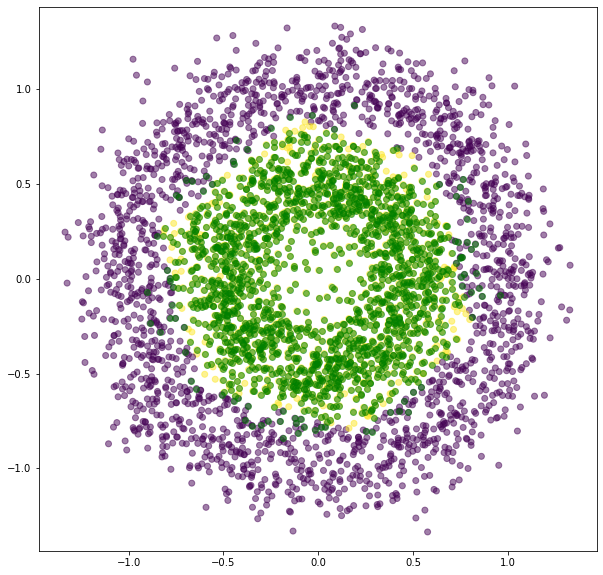

In [69]:
model_metrics2(train_circles.data, train_circles.labels, THRESHOLD, model)

In [ ]:
model2

In [ ]:
model_metrics2(test_circles.data, test_circles.labels, THRESHOLD, model2)

In [ ]:
def display_original_and_prediction(data, labels, threshold, model):
    
    

In [ ]:
model_metrics(train_circles.data, train_circles.labels, model2) , model_metrics(test_circles.data, test_circles.labels, model2)

In [ ]:
model_metrics(test_circles.data, test_circles.labels, model)

In [ ]:
draw_perceptron_boundary(model2.state_dict()['net.0.weight'].to('cpu').numpy(), 
                         model2.state_dict()['net.0.bias'].to('cpu').numpy())

In [ ]:
draw_perceptron_boundary(model.state_dict()['fc1.weight'].to('cpu').numpy(), 
                         model.state_dict()['fc1.bias'].to('cpu').numpy())